In [1]:
import os
# this allows for parallelization with pmap.
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)
import jax
import jax.numpy as jnp
import sys
sys.path.append('../src/')
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## Example of Algorithm 1: with $b = -\nabla V$


Here I use amortization, just to show it works.

In [2]:
potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    return -jax.grad(potential)(x)


s:  0.0
Train loss: 421590.78125
s:  0.1
Train loss: 104087.5390625
s:  0.5
Train loss: 8965.484375


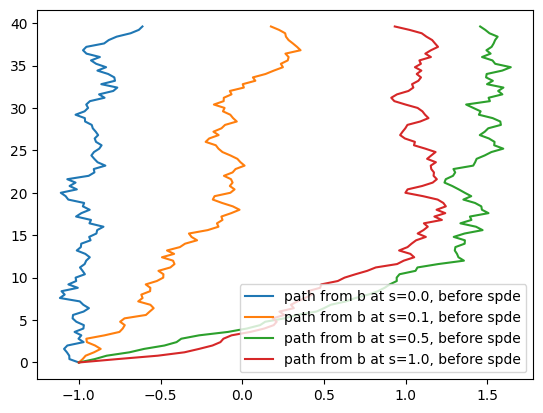

In [5]:
key = jax.random.key(0)
schedule = [0.1, 0.5, 1.0]


# currently we're just doing an SDE on \mathbb{R}
ndims = 1

b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A_TH = 0
for i, s in enumerate(schedule):


    key = jax.random.fold_in(key, i)

    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)
    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b,
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        refine=False,
        ndims=ndims
    )